# Capstone Project - The Battle of Neighborhoods

### Table of Contents

* [Introduction: Business Problem](#chapter1)
* [Description of the Data](#section_1_1)
* [Methodology](sSection_1_2)
* [Analysis of the Data](#section_1_2_1)
* [Results](#section_1_2_2)
* [Discussion](#section_1_2_3)
* [Conclusion](#chapter2)


### 1. Introduction: Business Problem

Istanbul is the most populated city in Turkey with an increasing migration constantly.  In order to meet the needs of the growing population, new amnesties establishes continuously,thus, arises new opportunities for enterprenuers. The aim of this project is the get insight for business purposes to find the best location to start a business like restaurants, cafe, arcade centers, and to get the best possible  profitability out of the investment. 

The tool that will be utilized in this project is the Foursquare API. The geographical data acquired from Foursquare API will be used to access the venues information and so to compare the neighborhoods by applying clustering algorithms and finally to choose best option among boroughs. 

### 2. Description of the Data 

Istanbul has 39 districts in total. The coordiantes of the boroughs of Istanbul attained from the Second-level Administrative Divisions of the Turkey from Spatial Data Repository of NYU. Also, the venues information of the boroughs are attained from Foursquare API. Furthermore, the center coordinates of the each Borough is determined by using Google Map, 'Search Nearby' option.

I will be using K-Means clustering model to analyze different clusters of boroughs and evaluate the venue information to establish a model which will determine the best location to start a business in Istanbul

###  3.Methodology


Some external libraries for clustering, mapping and visualizing the data

In [1]:
import numpy as np
import re
import json
import requests
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from geopy.geocoders import Nominatim
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


#### The data attained from Second-level Administrative Divisions of the Turkey from Spatial Data Repository of NYU and converted it into csv file

In [2]:
url = 'https://raw.githubusercontent.com/ganiyaman/finalist/main/latitude.csv'

istanbul_data = pd.read_csv(url)

istanbul_data.head()

,Borough,Latitude,Longitude
0,Adalar,40.8619,29.1208
1,Arnavutkoy,41.1956,28.7352
2,Atasehir,40.9831,29.1279
3,Avcilar,40.9880,28.7170
4,Bagcilar,41.0450,28.8338


#### Latitude and Longtitude values attained by using geopy library

In [3]:
address = 'Istanbul, TR'

geolocator = Nominatim(user_agent="Istanbul_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Istanbul are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Istanbul are 41.0096334, 28.9651646.


#### Using Latitude and Longtitude values, the map of istanbul is created by Folium library 

In [4]:
map_istanbul = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to map
for lat, lng, borough in zip(istanbul_data['Latitude'], istanbul_data['Longitude'], istanbul_data['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_istanbul)  
    
map_istanbul

#### Using Foursquare API, the venues of the Boroughs can be explored

In [5]:
CLIENT_ID = 'UE425WDY2G4Q1TTCBUUZOJXDK2KGPNGJO41B5BCHMTQRCRXB' # my Foursquare ID
CLIENT_SECRET = 'ULVTKLJ2ZRLC415QEBZY3IG5R3XQYFGVX2EL2LH02O1ESGVH' # my Foursquare Secret
VERSION = '20210102' # Foursquare API version
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UE425WDY2G4Q1TTCBUUZOJXDK2KGPNGJO41B5BCHMTQRCRXB
CLIENT_SECRET:ULVTKLJ2ZRLC415QEBZY3IG5R3XQYFGVX2EL2LH02O1ESGVH


#### the venues of the Boroughs can be explored by the definition

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### the data is stored in pandas dataframe

In [7]:
istanbul_venues = getNearbyVenues(names = istanbul_data['Borough'],
                                 latitudes = istanbul_data['Latitude'],
                                 longitudes = istanbul_data['Longitude']
                                 )

print(istanbul_venues.shape)
istanbul_venues.head()

(1812, 7)


,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.8619,29.1208,Büyükada Tepesi,40.861107,29.117418,Mountain
1,Adalar,40.8619,29.1208,Eski Rum Yetimhanesi,40.861705,29.123323,Historic Site
2,Adalar,40.8619,29.1208,Aşıklar butik by şükrü,40.862570,29.118003,Hotel
3,Adalar,40.8619,29.1208,Büyükada Bisiklet Parkuru,40.865000,29.116861,Bike Trail
4,Adalar,40.8619,29.1208,Nizam Butik Otel & Bistro,40.863322,29.116257,Bed & Breakfast


#### 1812 venues were found, and we can count per borough

In [8]:
summary = istanbul_venues.groupby('Borough').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Latitude', 'Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,Borough,Count
0,Arnavutkoy,9
1,BuyukCekmece,12
2,Pendik,13
3,Adalar,14
4,Tuzla,15


#### Least venue number is 9 which is in Arnavutkoy and 254 unique categories found

In [9]:
print('There are {} uniques categories.'.format(len(istanbul_venues['Venue Category'].unique())))

There are 254 uniques categories.


## 4. Analysis of the Data

#### Visualizing the number of venues per borough

<AxesSubplot:xlabel='Borough'>

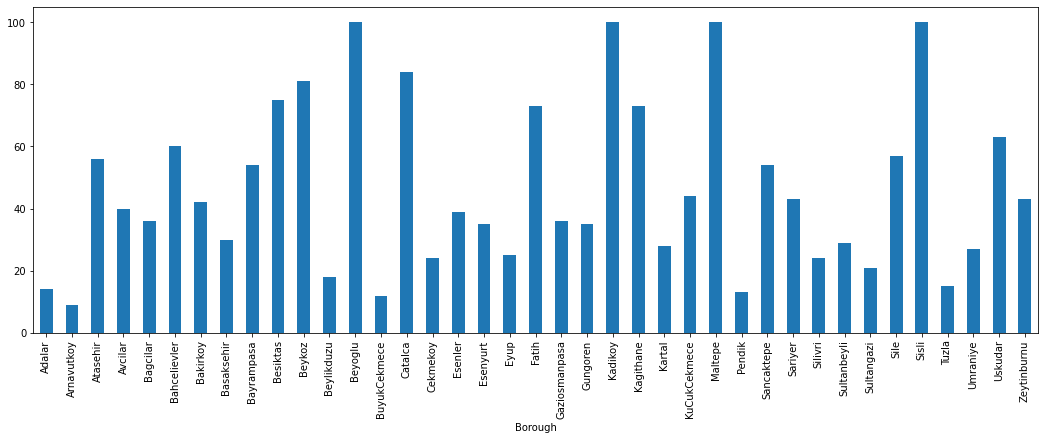

In [10]:
df = istanbul_venues.groupby(['Borough'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

#### The least number of venue is 9 

<AxesSubplot:xlabel='Borough'>

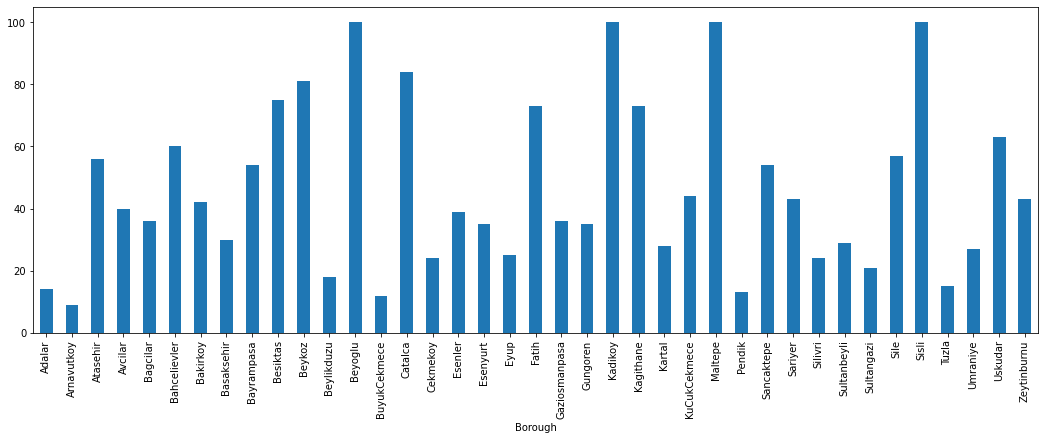

In [11]:
df = df[df >= 9]
df.plot.bar(figsize=(18,6))


#### Lets create a new dataframe that contains only the borough with 9+ venues and the venues with their details included.

In [12]:
istanbul_venues_top = istanbul_venues[istanbul_venues['Borough'].isin(df.index.tolist())]
istanbul_venues_top.head()

,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.8619,29.1208,Büyükada Tepesi,40.861107,29.117418,Mountain
1,Adalar,40.8619,29.1208,Eski Rum Yetimhanesi,40.861705,29.123323,Historic Site
2,Adalar,40.8619,29.1208,Aşıklar butik by şükrü,40.862570,29.118003,Hotel
3,Adalar,40.8619,29.1208,Büyükada Bisiklet Parkuru,40.865000,29.116861,Bike Trail
4,Adalar,40.8619,29.1208,Nizam Butik Otel & Bistro,40.863322,29.116257,Bed & Breakfast


#### One-Hot incoding

In [13]:
istanbul_onehot = pd.get_dummies(istanbul_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
istanbul_onehot['Borough'] = istanbul_venues_top['Borough'] 

# move neighborhood column to the first column
fixed_columns = istanbul_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Borough')))
istanbul_onehot = istanbul_onehot.reindex(columns = fixed_columns)

print(istanbul_onehot.shape)
istanbul_onehot.head()

(1812, 255)


,Borough,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Carpet Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Classroom,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Escape Room,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,General Travel,Gift Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indie Movie Theater,Insurance Office,Italian Restaurant,Jewelry Store,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Lake,Leather Goods Store,Lighthouse,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Mosque,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Opera House,Optical Shop,Other Event,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Café,Pharmacy,Pide Place,Pilavcı,Pizza Place,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Radio Station,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Söğüş Place,Taco Place,Tantuni Restaurant,Tea Room,Tech Startup,Tennis Court,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,Vegetarian / Vegan Restaurant,Volleyball Court,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Grouping the data with the mean of each occurance

In [14]:
istanbul_grouped = istanbul_onehot.groupby('Borough').mean().reset_index()
print(istanbul_grouped.shape)
istanbul_grouped.head()

(39, 255)


,Borough,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Carpet Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Classroom,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Escape Room,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,General Travel,Gift Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indie Movie Theater,Insurance Office,Italian Restaurant,Jewelry Store,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Lake,Leather Goods Store,Lighthouse,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Mosque,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Opera House,Optical Shop,Other Event,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Café,Pharmacy,Pide Place,Pilavcı,Pizza Place,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Radio Station,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Söğüş Place,Taco Place,Tantuni Restaurant,Tea Room,Tech Startup,Tennis Court,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Track,Trail,Tram Station,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,Vegetarian / Vegan Restaurant,Volleyball Court,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Çöp Şiş Place
0,Adalar,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.000,0.0,0.000000,0.0,0.0,0.071429,0.0,0.000000,0.0,0.0,0.071429,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.

#### Top venues for each borough

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### 9 most common venues in order to include every district and store it into new data frame

In [16]:
num_top_venues = 9

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = istanbul_grouped['Borough']

for ind in np.arange(istanbul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Adalar,Forest,Café,Garden Center,Nature Preserve,Historic Site,Hotel,Mountain,Tea Room,Bike Trail
1,Arnavutkoy,Shopping Mall,Big Box Store,Diner,Construction & Landscaping,Arcade,Convenience Store,Restaurant,Kofte Place,Leather Goods Store
2,Atasehir,Café,Coffee Shop,Pool,Spa,Soccer Stadium,Soccer Field,Breakfast Spot,Gym / Fitness Center,Restaurant
3,Avcilar,Café,Hotel,Turkish Restaurant,Cosmetics Shop,Pizza Place,Perfume Shop,Fast Food Restaurant,Moving Target,Modern European Restaurant
4,Bagcilar,Café,Turkish Restaurant,Kebab Restaurant,Gym,Steakhouse,Supermarket,Dessert Shop,Food Court,Department Store


#### k-Nearest Neighborhoods clustering with the silhouette_score to determine the best value of k

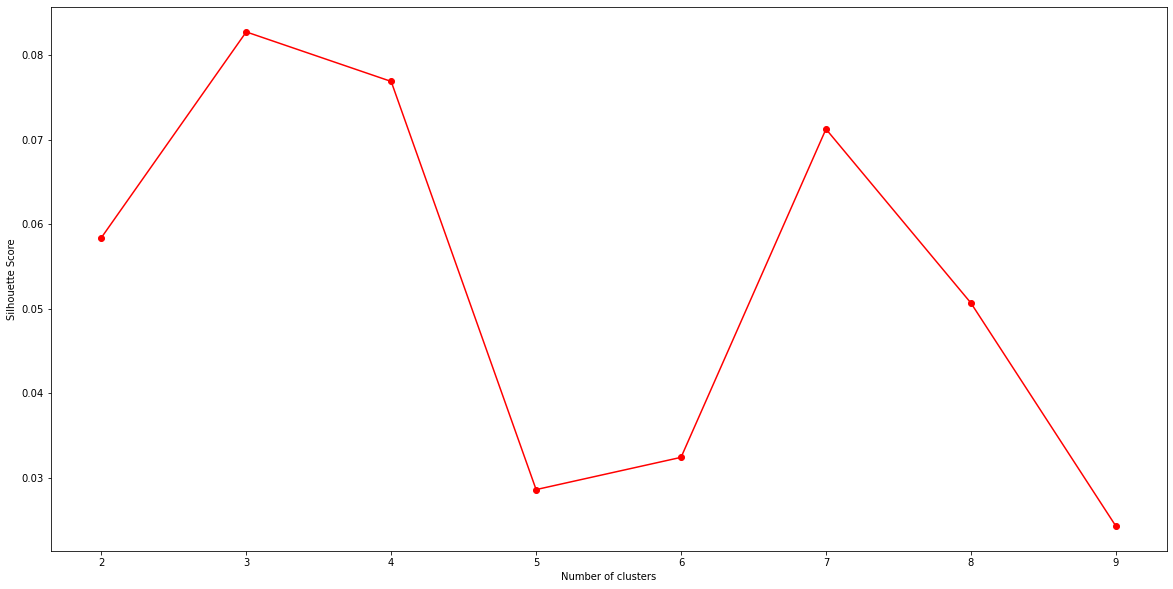

In [17]:
istanbul_grouped_clustering = istanbul_grouped.drop('Borough', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(istanbul_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(istanbul_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [93]:
istanbul_grouped_clustering = istanbul_grouped.drop('Borough', 1)

# Use silhouette score to find optimal number of clusters to segment the data
kclusters = np.arange(2,10)
results = {}
for size in kclusters:
    model = KMeans(n_clusters = size).fit(istanbul_grouped_clustering)
    predictions = model.predict(istanbul_grouped_clustering)
    results[size] = silhouette_score(istanbul_grouped_clustering, predictions)

best_size = max(results, key=results.get)
best_size

3

### best cluster number is 3

In [19]:
# select best number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(istanbul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 2, 1, 2, 2, 2, 1, 2, 2])

#### Add the cluster labels to the neighborhoods_venues_sorted dataframe. And lets create a new dataframe which has the neighborhood details, cluster labels and the 9 most common venues in that neighborhood.

In [20]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

istanbul_merged = istanbul_venues_top[istanbul_venues_top.columns[0:3]].drop_duplicates()
istanbul_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
istanbul_merged = istanbul_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

istanbul_merged.head(10)

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Adalar,40.8619,29.1208,1,Forest,Café,Garden Center,Nature Preserve,Historic Site,Hotel,Mountain,Tea Room,Bike Trail
1,Arnavutkoy,41.1956,28.7352,0,Shopping Mall,Big Box Store,Diner,Construction & Landscaping,Arcade,Convenience Store,Restaurant,Kofte Place,Leather Goods Store
2,Atasehir,40.9831,29.1279,2,Café,Coffee Shop,Pool,Spa,Soccer Stadium,Soccer Field,Breakfast Spot,Gym / Fitness Center,Restaurant
3,Avcilar,40.9880,28.7170,1,Café,Hotel,Turkish Restaurant,Cosmetics Shop,Pizza Place,Perfume Shop,Fast Food Restaurant,Moving Target,Modern European Restaurant
4,Bagcilar,41.0450,28.8338,2,Café,Turkish Restaurant,Kebab Restaurant,Gym,Steakhouse,Supermarket,Dessert Shop,Food Court,Department Store
5,Bahcelievler,40.9976,28.8500,2,Turkish Restaurant,Café,Kebab Restaurant,Bakery,Turkish Home Cooking Restaurant,Steakhouse,Gym,Men's Store,Motorcycle Shop
6,Bakirkoy,40.9835,28.8679,2,Gym,Turkish Restaurant,Park,Cosmetics Shop,Bookstore,Spa,Athletics & Sports,Comfort Food Restaurant,Food Court
7,Basaksehir,41.0969,28.7718,1,Café,Shopping Mall,Comfort Food Restaurant,Restaurant,Dessert Shop,Bakery,Halal Restaurant,Pool,Beer Garden
8,Bayrampasa,41.0477,28.8992,2,Clothing Store,Sporting Goods Shop,Restaurant,Café,Shopping Mall,Toy / Game Store,Cosmetics Shop,Department Store,Gym
9,Besiktas,41.0469,29.0078,2,Coffee Shop,Café,Pub,Hookah Bar,Chocolate Shop,Park,Turkish Restaurant,Performing Arts Venue,Music Venue


#### Randomly checking some dataset shape

In [21]:
istanbul_merged1 = istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 0, istanbul_merged.columns[[3, 4] + list(range(5, istanbul_merged.shape[1]))]]
istanbul_merged1.shape

(1, 10)

In [22]:
istanbul_merged2 = istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 1, istanbul_merged.columns[[3, 4] + list(range(5, istanbul_merged.shape[1]))]]
istanbul_merged2.shape

(8, 10)

#### Visualization of the density of Neighborhood by cluster label in a chart below

<AxesSubplot:ylabel='Cluster Labels'>

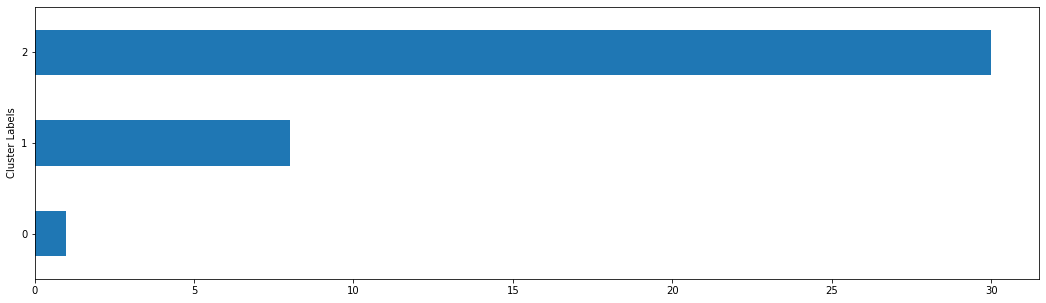

In [23]:
df = istanbul_merged.groupby(['Cluster Labels'], sort=True)['Borough'].count()
df.plot.barh(figsize=(18,5))

#### As can be seen in above dataframe, Cluster 2 contains the highest cluster density. The geographic centroid for this cluster is the most suitable location for the business start-up

In [24]:
Cluster_2_coorid = istanbul_merged[['Latitude', 'Longitude']]
Cluster_2_coorid = list(Cluster_2_coorid.values) 
lat = []
long = []



for l in Cluster_2_coorid:
  lat.append(l[0])
  long.append(l[1])



Blatitude = sum(lat)/len(lat)
Blongitude = sum(long)/len(long)
print(Blatitude)
print(Blongitude)

41.02541282051283
28.94954871794872


#### Install opencage to reverse lookup the coordinates

In [25]:
!pip install opencage
from opencage.geocoder import OpenCageGeocode
from pprint import pprint

key = '3a99b5016d2d4afbb5d9456248a2e58f'
geocoder = OpenCageGeocode(key)

results = geocoder.reverse_geocode(Blatitude, Blongitude)
pprint(results)

[{'annotations': {'DMS': {'lat': "41° 1' 30.79956'' N",
                          'lng': "28° 56' 57.05664'' E"},
                  'MGRS': '35TPF6387143386',
                  'Maidenhead': 'KN41la36vb',
                  'Mercator': {'x': 3222608.248, 'y': 4988009.258},
                  'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=95033330#map=16/41.02522/28.94918',
                          'note_url': 'https://www.openstreetmap.org/note/new#map=16/41.02522/28.94918&layers=N',
                          'url': 'https://www.openstreetmap.org/?mlat=41.02522&mlon=28.94918#map=16/41.02522/28.94918'},
                  'UN_M49': {'regions': {'ASIA': '142',
                                         'TR': '792',
                                         'WESTERN_ASIA': '145',
                                         'WORLD': '001'},
                             'statistical_groupings': ['LEDC']},
                  'callingcode': 90,
                  'currency': {'alternate_sy

In [26]:
#Obtain the popupstring of the best location
popstring = istanbul_data[istanbul_data['Borough'].str.contains('Fatih')]

def str_join(*args):
    return ''.join(map(str, args))

popstring_new = str_join('The Best suitable Neighbourhood to locate a New Business is in: ', popstring['Borough'].values)


print(popstring_new)

The Best suitable Neighbourhood to locate a New Business is in: ['Fatih']


In [27]:
address = 'Istanbul, TR'

geolocator = Nominatim(user_agent="Project 3A99B5")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of istanbul are {}, {}.'.format(latitude, longitude))

The geographical coordinate of istanbul are 41.0096334, 28.9651646.


## 5. Results

####  Finding the discriminating venue categories that distinguishes each cluster

###### Cluster 1

In [68]:
istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 0, istanbul_merged.columns[[0] + list(range(4, istanbul_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
1,Arnavutkoy,Shopping Mall,Big Box Store,Diner,Construction & Landscaping,Arcade,Convenience Store,Restaurant,Kofte Place,Leather Goods Store


In [69]:
cluster1 = istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 0, istanbul_merged.columns[[0] + 
                                                                                    list(range(4, istanbul_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']))

print(venues1.value_counts().head(9))

Construction & Landscaping    1
Convenience Store             1
Big Box Store                 1
Kofte Place                   1
Leather Goods Store           1
Diner                         1
Shopping Mall                 1
Restaurant                    1
Arcade                        1
dtype: int64


##### Cluster 2

In [70]:
istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 1, istanbul_merged.columns[[0] + list(range(4, istanbul_merged.shape[1]))]]


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Adalar,Forest,Café,Garden Center,Nature Preserve,Historic Site,Hotel,Mountain,Tea Room,Bike Trail
3,Avcilar,Café,Hotel,Turkish Restaurant,Cosmetics Shop,Pizza Place,Perfume Shop,Fast Food Restaurant,Moving Target,Modern European Restaurant
7,Basaksehir,Café,Shopping Mall,Comfort Food Restaurant,Restaurant,Dessert Shop,Bakery,Halal Restaurant,Pool,Beer Garden
18,Eyup,Café,Soccer Field,Historic Site,Restaurant,Turkish Restaurant,Mosque,Scenic Lookout,Tea Room,Bath House
20,Gaziosmanpasa,Café,Steakhouse,Coffee Shop,Turkish Restaurant,Snack Place,Bookstore,Taco Place,Mobile Phone Shop,Diner
22,Kadikoy,Café,Soccer Stadium,Coffee Shop,Theater,Bridal Shop,Fast Food Restaurant,Performing Arts Venue,Pub,Dessert Shop
32,Sultangazi,Café,Park,Shopping Mall,Turkish Home Cooking Restaurant,Music Venue,Pizza Place,Bagel Shop,Fast Food Restaurant,Men's Store
37,Uskudar,Café,Coffee Shop,Tea Room,Turkish Restaurant,Plaza,Mosque,Sporting Goods Shop,Gym / Fitness Center,Grocery Store


In [71]:
cluster2 = istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 1, istanbul_merged.columns[[0] + 
                                                                                    list(range(4, istanbul_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']))

print(venues2.value_counts().head(9))

Café                    8
Turkish Restaurant      4
Fast Food Restaurant    3
Coffee Shop             3
Tea Room                3
Dessert Shop            2
Historic Site           2
Shopping Mall           2
Restaurant              2
dtype: int64


##### Cluster 3

In [72]:
istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 2, istanbul_merged.columns[[0] + list(range(4, istanbul_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
2,Atasehir,Café,Coffee Shop,Pool,Spa,Soccer Stadium,Soccer Field,Breakfast Spot,Gym / Fitness Center,Restaurant
4,Bagcilar,Café,Turkish Restaurant,Kebab Restaurant,Gym,Steakhouse,Supermarket,Dessert Shop,Food Court,Department Store
5,Bahcelievler,Turkish Restaurant,Café,Kebab Restaurant,Bakery,Turkish Home Cooking Restaurant,Steakhouse,Gym,Men's Store,Motorcycle Shop
6,Bakirkoy,Gym,Turkish Restaurant,Park,Cosmetics Shop,Bookstore,Spa,Athletics & Sports,Comfort Food Restaurant,Food Court
8,Bayrampasa,Clothing Store,Sporting Goods Shop,Restaurant,Café,Shopping Mall,Toy / Game Store,Cosmetics Shop,Department Store,Gym
9,Besiktas,Coffee Shop,Café,Pub,Hookah Bar,Chocolate Shop,Park,Turkish Restaurant,Performing Arts Venue,Music Venue
10,Beykoz,Café,Turkish Restaurant,Dessert Shop,Restaurant,Breakfast Spot,Bistro,Electronics Store,Clothing Store,Pool Hall
11,Beylikduzu,Steakhouse,Accessories Store,Turkish Restaurant,Pide Place,Convenience Store,Restaurant,Department Store,Business Service,Shopping Mall
12,Beyoglu,Hotel,Restaurant,Café,Coffee Shop,Bar,Art Gallery,Cocktail Bar,Turkish Home Cooking Restaurant,Italian Restaurant
13,BuyukCekmece,Seafood Restaurant,Surf Spot,Paintball Field,Café,River,Snack Place,Volleyball Court,Whisky Bar,Steakhouse


In [73]:
cluster3 = istanbul_merged.loc[istanbul_merged['Cluster Labels'] == 2, istanbul_merged.columns[[0] + 
                                                                                    list(range(4, istanbul_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']))

print(venues3.value_counts().head(9))

Café                  28
Turkish Restaurant    20
Restaurant            14
Dessert Shop           9
Coffee Shop            9
Gym                    7
Breakfast Spot         7
Steakhouse             7
Bakery                 6
dtype: int64


#### Distribution of venues among clusters

IndexError: list index out of range

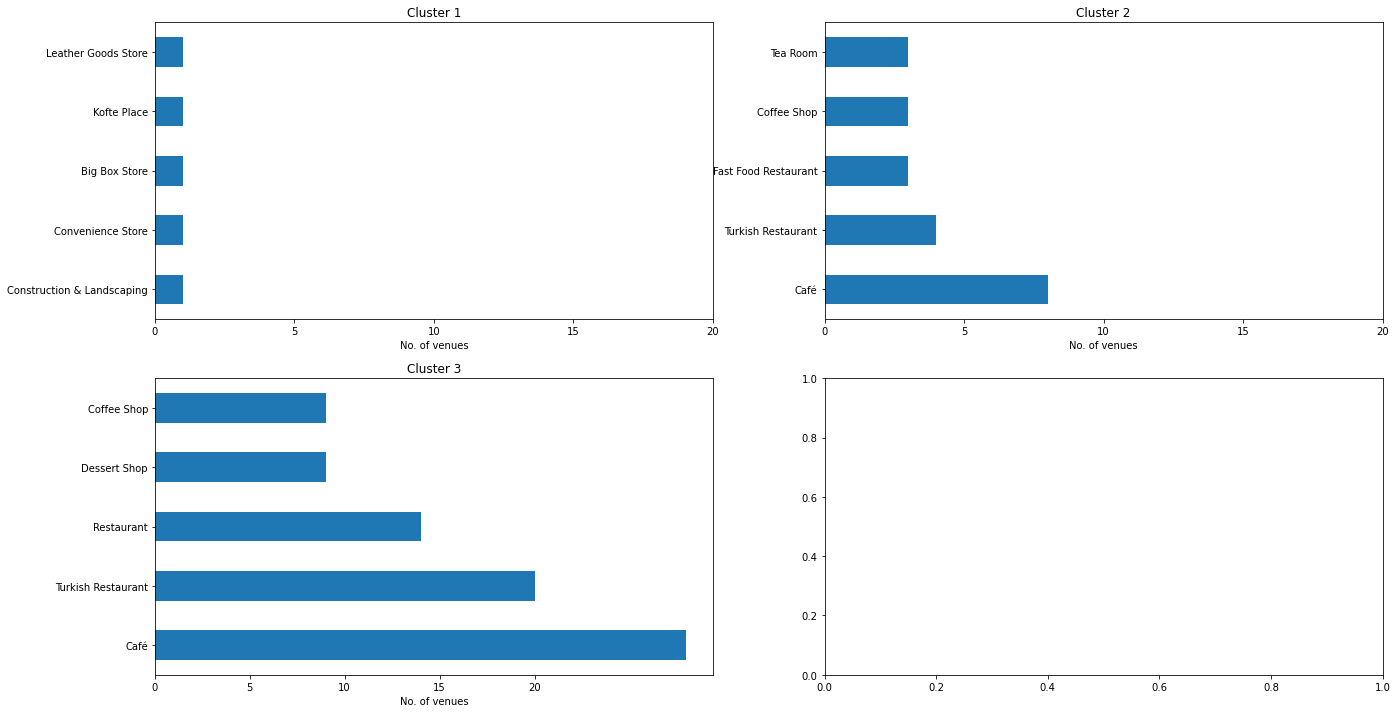

In [95]:
df_list = [venues1 ,venues2, venues3]
fig, axes = plt.subplots(2, 2)

count = 0
for r in range(2):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(22,12))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 25, 5))
        plt.xlabel('No. of venues')
        count += 1
        

fig.tight_layout()

## 6. Discussion

These above plots can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business

##### A.Cafe

Cluster 3 has the highest number of cafe. To start a succesful business we should find a place which has least number of the amnsety. Thus, Cluster 1 which is Arnavutkoy could be the best option for openning a cafe. Also, Cluster 2 could be the other option. 

##### B.Fast Food Restaurant

CLuster 3 seems to be best attraction for people as most of amnesties established in that region. This could be a good sign of locating a place to start-up a business. Also, our best place Fatih that we found before is also located in that cluster. However, there is not much Fast Food Restaurant in that region. So, it could be a good option to run a business in cluster 3

##### C.Tea Room

Another popular amnesty is the room that is on the list in Cluster 2. However, we could not see much tea room in cluster 3. SO, it could be good option for cluster 3  

##### D.Dessert Shop

We can see the high similarity between cluster 2 and cluster 3 in terms of amnesties. Therefore, we could suggest the Dessert Shop for cluster 2  

#### Map of Istanbul with the clusters superimposed on top

This map can be used to find a suitable location to start a new business based on the Venue category.

I have added a most suitable location on Istanbul map based on above analytics for a new business set-up

In [61]:
# getfolium
import folium 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(istanbul_merged['Latitude'], istanbul_merged['Longitude'], istanbul_merged['Borough'], istanbul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
    
folium.CircleMarker([Blatitude, Blongitude],
                    radius=50,
                    popup='Istanbul',
                    color='red',
                    ).add_to(map_clusters)

# Interactive marker
map_clusters.add_child(folium.ClickForMarker(popup=popstring_new))
       
#map_clusters
map_clusters.save('map_clusters.html')


map_clusters

This map can also be used to select a vast suggestion area for a particular type of business based on the category

### 7. Conclusion

The objective of this project was to analyze the boroughs of Istanbul and create a clustering model to suggest potential places to start a new business based on the category. The neighborhoods data was obtained from the Second-level Administrative Divisions of the Turkey from Spatial Data Repository of NYU and the Foursquare API was used to find the major venues in each neighborhood. Locations were used to create a clustering model. The best number of clusters i.e. 3 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model